# Image Segmentation Practical Work

In [36]:
# modules
import math
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, filters
from sklearn.cluster import KMeans
from sklearn.utils import shuffle
import skimage.morphology as morpho

In [37]:
# usefull functions
def sobelGradX(ima):

    nl,nc=ima.shape
    gradx=np.zeros((nl,nc))

    for i in range(1,nl-1):
        for j in range(1,nc-1):
            gradx[i,j]=ima[i-1,j+1]+2*ima[i,j+1]+ima[i+1,j+1]-ima[i-1,j-1]-2*ima[i,j-1]-ima[i+1,j-1];
            
    return gradx
              

def sobelGradY(ima):

    nl,nc=ima.shape
    grady=np.zeros((nl,nc))


    for i in range(1,nl-1):
        for j in range(1,nc-1):
            grady[i,j]=ima[i+1,j-1]+2*ima[i+1,j]+ima[i+1,j+1]-ima[i-1,j-1]-2*ima[i-1,j]-ima[i-1,j+1];
        
    return grady

def interpolationbilineaire(ima,l,c):

    l,c
    
    l1=l-np.floor(l)
    l2=np.ceil(l)-l
    c1=c-np.floor(c)
    c2=np.ceil(c)-c   


    ll=np.uint32(np.floor(l))
    cc=np.uint32(np.floor(c))

    val=ima[ll,cc]*l2*c2+ima[ll+1,cc]*l1*c2+ima[ll,cc+1]*l2*c1+ima[ll+1,cc+1]*l1*c1

    return val 

def maximaDirectionGradient(gradx,grady,seuil=0.0001):


    nl,nc=gradx.shape
    
    norme=np.sqrt(gradx*gradx+grady*grady)+0.0001

    gradx=np.divide(gradx,norme)
    grady=np.divide(grady,norme)
 
    contours=np.zeros((nl,nc),dtype=int);

    for i in range(1,nl-1):
        for j in range(1,nc-1):
            G1=interpolationbilineaire(norme,i+grady[i,j],j+gradx[i,j]); 
            G2=interpolationbilineaire(norme,i-grady[i,j],j-gradx[i,j]); 
            if norme[i,j]>=G1 and norme[i,j]>=G2 and norme[i,j]>seuil:
                contours[i,j]=1
            else:
                contours[i,j]=0

    return contours

def dericheGradX(ima,alpha):

    
    nl,nc=ima.shape
    ae=math.exp(-alpha)
    c=-(1-ae)*(1-ae)/ae

    b1=np.zeros(nc)
    b2=np.zeros(nc)

    gradx=np.zeros((nl,nc))

    for i in range(nl):
        
        l=ima[i,:].copy()
        
        for j in range(2,nc):
            b1[j] = l[j-1]     # LIGNE A MODIFIER
        b1[0]=b1[2]
        b1[1]=b1[2]
        
        for j in range(nc-3,-1,-1):
            b2[j] = l[j+1]    # LIGNE A MODIFIER
        b2[nc-2]=b2[nc-3]
        b2[nc-1]=b2[nc-3]

        gradx[i,:]=c*ae*(b1-b2);
  
    return gradx


def dericheGradY(ima,alpha):

    
    nl,nc=ima.shape
    ae=math.exp(-alpha)
    c=-(1-ae)*(1-ae)/ae

    b1=np.zeros(nl)
    b2=np.zeros(nl)

    grady=np.zeros((nl,nc))

    for i in range(nc):
        
        l=ima[:,i].copy()
        
        for j in range(2,nl):
            b1[j]=l[j-1]   # LIGNE A MODIFIER
        b1[0]=b1[2]
        b1[1]=b1[2]      
        
        for j in range(nl-3,-1,-1):
            b2[j]=l[j+1]    # LIGNE A MODIFIER
        b2[nl-1]=b2[nl-3]
        b2[nl-2]=b2[nl-3]
        
        grady[:,i]=c*ae*(b1-b2);
        
    
    return grady


def dericheSmoothX(ima,alpha):

    
    nl,nc=ima.shape
    ae=math.exp(-alpha)
    c=(1-ae)*(1-ae)/(1+2*alpha*ae-ae*ae)


    b1=np.zeros(nc)
    b2=np.zeros(nc)

    smoothx=np.zeros((nl,nc))

    for i in range(nl):
        l=ima[i,:].copy()
        for j in range(2,nc):
            b1[j]=c*(l[j]+ae*(alpha-1)*l[j-1])+2*ae*b1[j-1]-ae*ae*b1[j-2]
        b1[0]=b1[2]
        b1[1]=b1[2]
        for j in range(nc-3,-1,-1):
            b2[j]=c*(ae*(alpha+1)*l[j+1]-ae*ae*l[j+2])+2*ae*b2[j+1]-ae*ae*b2[j+2]
        b2[nc-1]=b2[nc-3]
        b2[nc-2]=b2[nc-3]
        smoothx[i,:]=b1+b2
        
    
    return smoothx

def dericheSmoothY(ima,alpha):

    
    nl,nc=ima.shape
    ae=math.exp(-alpha)
    c=(1-ae)*(1-ae)/(1+2*alpha*ae-ae*ae)

    b1=np.zeros(nl)
    b2=np.zeros(nl)

    smoothy=np.zeros((nl,nc))

    for i in range(nc):
        l=ima[:,i].copy()
        for j in range(2,nl):
            b1[j]=c*(l[j]+ae*(alpha-1)*l[j-1])+2*ae*b1[j-1]-ae*ae*b1[j-2]
        b1[0]=b1[2]
        b1[1]=b1[2]      
        for j in range(nl-3,-1,-1):
            b2[j]=c*(ae*(alpha+1)*l[j+1]-ae*ae*l[j+2])+2*ae*b2[j+1]-ae*ae*b2[j+2]
        b2[nl-1]=b2[nl-3]
        b2[nl-2]=b2[nl-3]
        
        smoothy[:,i]=b1+b2
        
    
    return smoothy

def median_filter(im,typ=1,r=1,xy=None):
    
    lx=[]
    ly=[]
    (ty,tx)=im.shape
    if typ==1: # square
        
        for k in range(-r,r+1):
            for l in range(-r,r+1):
                lx.append(k)
                ly.append(l)
        
    elif typ==2: # disk
        for k in range(-r,r+1):
            for l in range(-r,r+1):
                if k**2+l**2<=r**2:
                    lx.append(k)
                    ly.append(l)
    else: # freeshape
        lx,ly=xy
    
    debx=-min(lx) #min is supposed negative
    deby=-min(ly)
    finx=tx-max(lx) #max is supposed positive
    finy=ty-max(ly)
    ttx=finx-debx
    tty=finy-deby
    tab=np.zeros((len(lx),ttx*tty))
    for k in range(len(lx)):
        tab[k,:]=im[deby+ly[k]:deby+tty+ly[k],debx+lx[k]:debx+ttx+lx[k]].reshape(-1)
    out=im.copy()
    out[deby:finy,debx:finx]=np.median(tab,axis=0).reshape((tty,ttx))
    return out

def recreate_image(codebook, labels, w, h):
    """Recreate the (compressed) image from the code book & labels"""
    d = codebook.shape[1]
    image = np.zeros((w, h, d))
    label_idx = 0
    for i in range(w):
        for j in range(h):
            image[i][j] = codebook[labels[label_idx]]
            label_idx += 1
    return image

def histogram(im):
    
    nl,nc=im.shape
    
    hist=np.zeros(256)
    
    for i in range(nl):
        for j in range(nc):
            hist[im[i][j]]=hist[im[i][j]]+1
            
    for i in range(256):
        hist[i]=hist[i]/(nc*nl)
        
    return(hist)

## 1. Edge Detection

### 1.1 Sobel Filter
The Sobel filter detects edges by calculating the image gradient. This section applies a Sobel filter, thresholds the gradient norm, and evaluates the results.

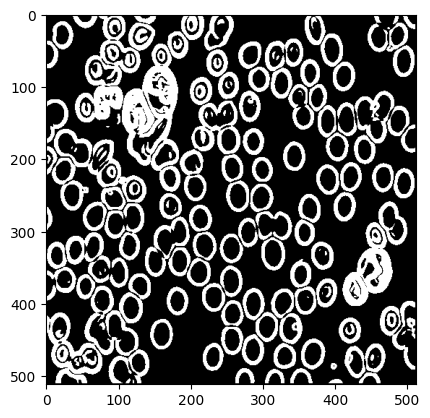

In [38]:
image = io.imread('cell.tif')
sigma = 2
seuilnorme = 0.06

gfima = filters.gaussian(image,sigma)
gradx = sobelGradX(gfima)
grady = sobelGradY(gfima)  

norme = np.sqrt(gradx*gradx+grady*grady)

contoursnorme = (norme>seuilnorme)


plt.figure('Norme seuillée')
plt.imshow(255*contoursnorme, cmap='gray')

### 1.2 Maxima in Gradient Direction
Identifies local maxima in the gradient direction. This helps refine edge detection by isolating prominent contours.

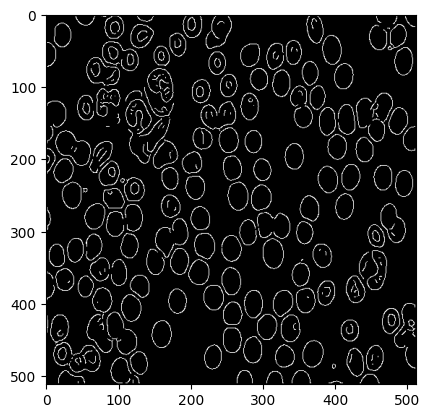

In [39]:
contours = np.uint8(maximaDirectionGradient(gradx,grady))
valcontours = (norme>seuilnorme)*contours
      
plt.figure('norme')
plt.imshow(255*valcontours, cmap='gray')
plt.show()

### 1.3 Zero-Crossing of Laplacian
Uses the Laplacian operator to detect zero-crossings, highlighting changes in image intensity.

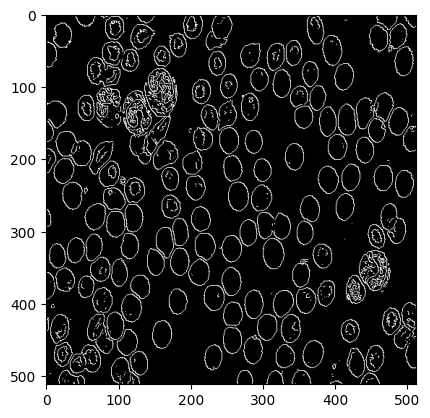

In [40]:
sigma = 7
gfima = filters.gaussian(image,sigma)
alpha = 3

gradx = dericheGradX(dericheSmoothY(image,alpha),alpha)
grady = dericheGradY(dericheSmoothX(image,alpha),alpha)  

gradx2 = dericheGradX(dericheSmoothY(gradx,alpha),alpha)
grady2 = dericheGradY(dericheSmoothX(grady,alpha),alpha)  

lpima = gradx2+grady2
posneg = (lpima>=0)

nl,nc = image.shape
contours = np.uint8(np.zeros((nl,nc)))


for i in range(1,nl):
    for j in range(1,nc):
        if (((i>0) and (posneg[i-1,j] != posneg[i,j])) or
            ((j>0) and (posneg[i,j-1] != posneg[i,j]))):
            contours[i,j]=255
            
contours *= (np.sqrt(gradx*gradx+grady*grady)>5)
   
plt.figure('Contours')
plt.imshow(contours, cmap='gray')
plt.show()

## 2. K-Means Classification

### 2.1 Grayscale Images
Clusters pixels of grayscale images into distinct classes using K-Means.

Fitting model on a small sub-sample of the data
Predicting color indices on the full image (k-means)


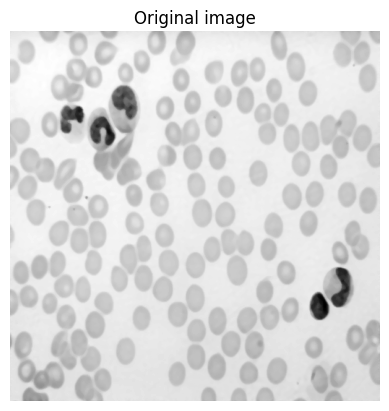

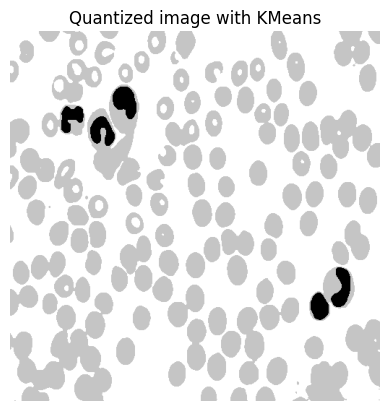

[[0.56189237]
 [0.65133442]
 [0.25882353]]


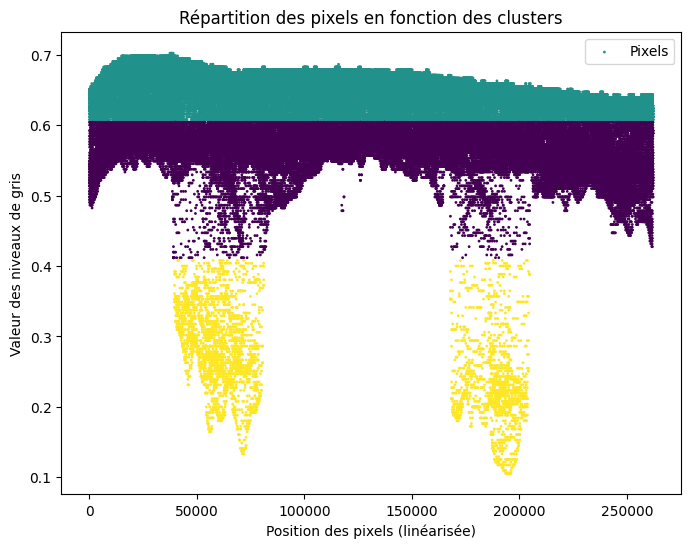

In [41]:
n_class = 3

image = median_filter(image,2,3)
image = np.array(image, dtype=np.float64) / 255

w, h = original_shape = tuple(image.shape)
d = 1
image_array = np.reshape(image, (w * h, d))

print("Fitting model on a small sub-sample of the data")
image_array_sample = shuffle(image_array, random_state=0)[:1000]
kmeans = KMeans(n_clusters=n_class,random_state=0).fit(image_array_sample)


# Get labels for all points
print("Predicting color indices on the full image (k-means)")
labels = kmeans.predict(image_array)

# Display all results, alongside original image
plt.figure(1)
plt.clf()
plt.axis('off')
plt.title('Original image')
plt.imshow(image,cmap='gray')

centroids = kmeans.cluster_centers_

plt.figure(2)
plt.clf()
plt.axis('off')
plt.title('Quantized image with KMeans')
plt.imshow(recreate_image(centroids, labels, w, h),cmap='gray')
plt.show()
print(centroids)

plt.figure(figsize=(8, 6))
plt.scatter(np.arange(w*h), image_array.flatten(), c=labels, s=1, cmap='viridis', label='Pixels')  # Affichage des centroïdes
plt.title("Répartition des pixels en fonction des clusters")
plt.xlabel("Position des pixels (linéarisée)")
plt.ylabel("Valeur des niveaux de gris")
plt.legend()
plt.show()

### 2.2 Color Images
Applies K-Means to color images

Fitting model on a small sub-sample of the data
Predicting color indices on the full image (k-means)


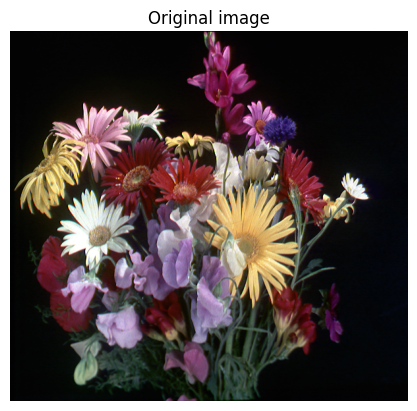

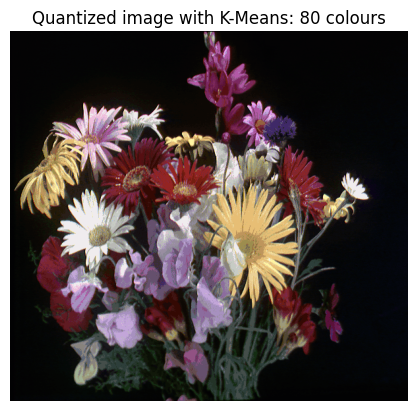

In [42]:
n_colors = 80

image = io.imread("fleur.tif")
image = np.array(image, dtype=np.float64) / 255

# Load Image and transform to a 2D numpy array.
w, h, d = original_shape = tuple(image.shape)
assert d == 3
image_array = np.reshape(image, (w * h, d))

print("Fitting model on a small sub-sample of the data")
image_array_sample = shuffle(image_array, random_state=0)[:1000]
kmeans = KMeans(n_clusters=n_colors, init='random').fit(image_array_sample)


# Get labels for all points
print("Predicting color indices on the full image (k-means)")
labels = kmeans.predict(image_array)

# Display all results, alongside original image
plt.figure(1)
plt.clf()
plt.axis('off')
plt.title('Original image')
plt.imshow(image)

plt.figure(2)
plt.clf()
plt.axis('off')
plt.title('Quantized image with K-Means: %i colours' %n_colors)
plt.imshow(recreate_image(kmeans.cluster_centers_, labels, w, h))
plt.show()

## 3. Automatic Thresholding: Otsu Method

Applies Otsu's method for automatic thresholding by minimizing intra-class variance.

Otsu treshold : 153


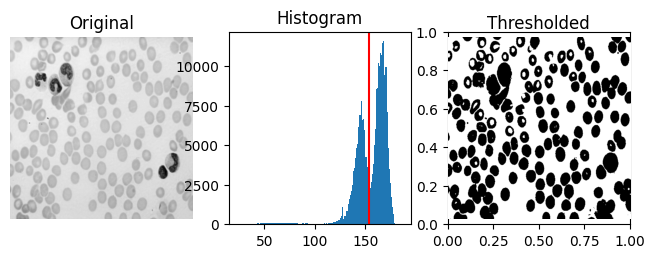

In [43]:
def otsu_thresh(im):
    
    h=histogram(im)
    
    m=0
    for i in range(256):
        m=m+i*h[i]
    
    maxt=0
    maxk=0
    
    
    for t in range(256):
        w0=0
        w1=0
        m0=0
        m1=0
        for i in range(t):
            w0=w0+h[i]
            m0=m0+i*h[i]
        if w0 > 0:
            m0=m0/w0
        
        for i in range(t,256):
            w1=w1+h[i]
            m1=m1+i*h[i]
        if w1 > 0:   
            m1=m1/w1
        
        k=w0*w1*(m0-m1)*(m0-m1)    
        
        if k > maxk:
            maxk=k
            maxt=t
            
            
    thresh=maxt
        
    return(thresh)


image = io.imread('cell.tif')

thresh = otsu_thresh(image)
binary = image > thresh
print('Otsu treshold :',thresh)

fig, axes = plt.subplots(ncols=3, figsize=(8, 2.5))
ax = axes.ravel()
ax[0] = plt.subplot(1, 3, 1)
ax[1] = plt.subplot(1, 3, 2)
ax[2] = plt.subplot(1, 3, 3, sharex=ax[0], sharey=ax[0])

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Original')
ax[0].axis('off')

bins=np.max(image)-np.min(image)+1

ax[1].hist(image.ravel(), bins=bins)
ax[1].set_title('Histogram')
ax[1].axvline(thresh, color='r')

ax[2].imshow(binary, cmap=plt.cm.gray)
ax[2].set_title('Thresholded')
ax[2].axis('off')

plt.show()

## 4. Region Growing

Explores the region growing method for segmenting regions of interest, such as white matter in `cerveau.tif`.

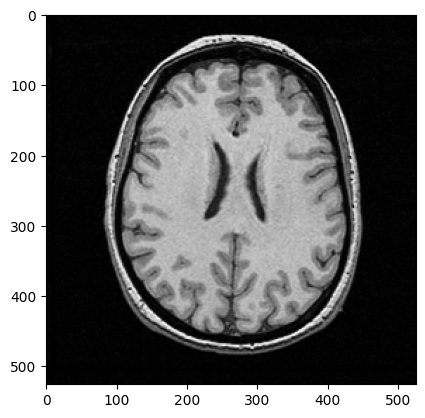

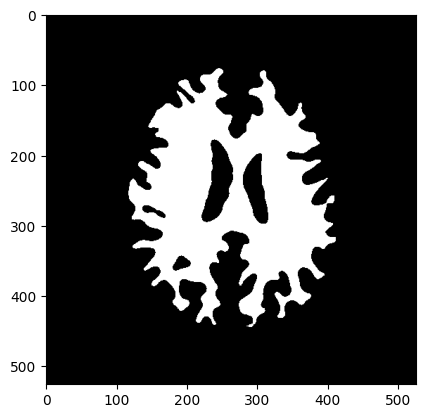

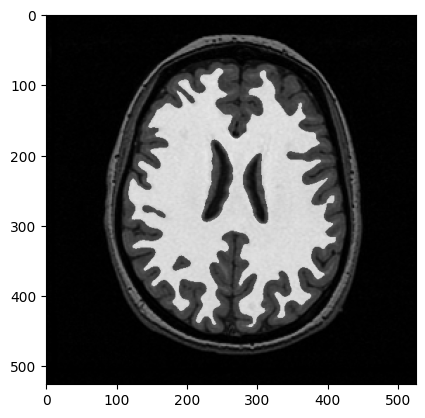

In [47]:
def perimeter(im):
    se=morpho.disk(1)
    dil=morpho.dilation(im,se)
    diff=dil-im
    ta=np.nonzero(diff)
    return ta
     

im = io.imread('cerveau.tif')
mask=np.zeros((len(im),len(im[0])))

plt.figure('Image originale')
plt.imshow(im,cmap='gray')
plt.show()


### parameters
# germ initial position
y0 = 300
x0 = 300
# predicate threshold
thresh = 3
# neighbourhood for local mean and standard deviation calculus
rayon = 5

# initial mask
mask[y0,x0] = 255

ext=im[y0-rayon:y0+rayon+1,x0-rayon:x0+rayon+1]
m0=np.mean(ext)
s0=np.std(ext)

modif = 1
iter = 0 

while modif > 0:

    iter += 1
        
    modif = 0
    
    per = perimeter(mask)

    for i in range (0 , len(per[0])):

        y = per[0][i]
        x = per[1][i]
        ext = im[y-rayon:y+rayon+1,x-rayon:x+rayon+1]
        m = np.mean(ext)
        s = np.std(ext)

        if np.abs(m0-m) < thresh * s0 :
            mask[y][x] = 255
            modif = 1


plt.figure('masque')
plt.imshow(mask,cmap='gray')
plt.show()


se=morpho.disk(1)
dil=morpho.dilation(mask,se)
diff=dil-mask

plt.figure('superposition')
plt.imshow(im, cmap='gray')
plt.imshow(mask, cmap='gray', alpha=0.5)
plt.show()